In [1]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 58.0 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 109.3 MB/s eta 0:00:00


In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms
import timm

from sklearn.cluster import KMeans

SEED = 6174
np.random.seed(SEED)

# Set the folder path for data
folder_path = "./input"

In [3]:
de_train = pd.read_parquet(f'{folder_path}/de_train.parquet')
genes = de_train.columns[5:]
id_map = pd.read_csv (f'{folder_path}/id_map.csv')
id_map = id_map.reindex(id_map.columns.tolist() + genes.tolist(), axis=1)

sm_lincs_id = de_train.set_index('sm_name')["sm_lincs_id"].to_dict()
sm_name_to_smiles = de_train.set_index('sm_name')['SMILES'].to_dict()

id_map['sm_lincs_id'] = id_map['sm_name'].map(sm_lincs_id)
id_map['SMILES'] = id_map['sm_name'].map(sm_name_to_smiles)

de_train

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,NK cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.104720,-0.077524,-1.625596,-0.144545,0.143555,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,T cells CD4+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.915953,-0.884380,0.371834,-0.081677,-0.498266,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
2,T cells CD8+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,-0.387721,-0.305378,0.567777,0.303895,-0.022653,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365
3,T regulatory cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.232893,0.129029,0.336897,0.486946,0.767661,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
4,NK cells,Mometasone Furoate,LSM-3349,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,False,4.290652,-0.063864,-0.017443,-0.541154,0.570982,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,T regulatory cells,Atorvastatin,LSM-5771,CC(C)c1c(C(=O)Nc2ccccc2)c(-c2ccccc2)c(-c2ccc(F...,False,-0.014372,-0.122464,-0.456366,-0.147894,-0.545382,...,-0.549987,-2.200925,0.359806,1.073983,0.356939,-0.029603,-0.528817,0.105138,0.491015,-0.979951
610,NK cells,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,-0.455549,0.188181,0.595734,-0.100299,0.786192,...,-1.236905,0.003854,-0.197569,-0.175307,0.101391,1.028394,0.034144,-0.231642,1.023994,-0.064760
611,T cells CD4+,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,0.338168,-0.109079,0.270182,-0.436586,-0.069476,...,0.077579,-1.101637,0.457201,0.535184,-0.198404,-0.005004,0.552810,-0.209077,0.389751,-0.337082
612,T cells CD8+,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,0.101138,-0.409724,-0.606292,-0.071300,-0.001789,...,0.005951,-0.893093,-1.003029,-0.080367,-0.076604,0.024849,0.012862,-0.029684,0.005506,-1.733112


In [4]:
## Drop cell_type = 'T cells CD4+', 'T cells CD8+'
#de_train.drop(de_train[de_train['cell_type'] == 'T cells CD4+'].index, inplace = True)
#de_train.drop(de_train[de_train['cell_type'] == 'T cells CD8+'].index, inplace = True)

#de_train

In [5]:
all_sm_names = de_train[de_train["cell_type"]=="B cells"]["sm_name"].to_list()
all_de_train = de_train[de_train["sm_name"].isin(all_sm_names)]
#de_train.drop(all_de_train.index, inplace=True)

all_de_train

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
8,B cells,Idelalisib,LSM-1205,CC[C@H](Nc1ncnc2[nH]cnc12)c1nc2cccc(F)c2c(=O)n...,False,0.394173,-0.153824,0.178232,0.566241,0.391377,...,-1.052302,-1.176587,-1.220291,-0.278944,-0.095066,1.101790,0.061803,1.406335,-0.264996,-0.119743
9,Myeloid cells,Idelalisib,LSM-1205,CC[C@H](Nc1ncnc2[nH]cnc12)c1nc2cccc(F)c2c(=O)n...,False,0.025146,0.316388,1.366885,1.301593,2.317619,...,-0.902546,-1.445523,0.794772,0.428973,0.605834,0.271988,0.492231,0.354721,1.471559,-0.259483
10,NK cells,Idelalisib,LSM-1205,CC[C@H](Nc1ncnc2[nH]cnc12)c1nc2cccc(F)c2c(=O)n...,False,0.861487,-0.112313,-0.355217,0.719999,0.655865,...,0.035687,0.138060,-0.776619,-0.109832,-0.189906,0.753086,0.190892,-0.141699,-0.756510,-0.076934
11,T cells CD4+,Idelalisib,LSM-1205,CC[C@H](Nc1ncnc2[nH]cnc12)c1nc2cccc(F)c2c(=O)n...,False,0.206471,0.014638,-0.247518,0.430198,0.103020,...,-0.018902,-1.013426,-1.196254,-0.983257,1.097309,-0.090271,-1.293485,0.118196,-0.120892,-0.411331
12,T cells CD8+,Idelalisib,LSM-1205,CC[C@H](Nc1ncnc2[nH]cnc12)c1nc2cccc(F)c2c(=O)n...,False,0.046959,-0.346839,0.023478,0.485611,0.005066,...,0.017437,0.537964,-0.219895,0.376181,0.706930,-0.554368,0.035559,-0.189976,-0.145465,0.109084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,Myeloid cells,CHIR-99021,LSM-1181,Cc1cnc(-c2cnc(NCCNc3ccc(C#N)cn3)nc2-c2ccc(Cl)c...,False,0.338227,-0.431007,0.066335,-0.907600,0.973881,...,0.187125,0.800574,0.214946,-0.104931,-0.125619,-0.160210,-0.886414,-2.955785,-0.866944,-0.053017
558,NK cells,CHIR-99021,LSM-1181,Cc1cnc(-c2cnc(NCCNc3ccc(C#N)cn3)nc2-c2ccc(Cl)c...,False,-1.026443,-0.024840,0.204772,-0.861985,-2.972540,...,0.323512,1.131738,-0.064157,0.011429,0.030404,0.015837,-0.055027,-0.329874,0.327199,-0.830306
559,T cells CD4+,CHIR-99021,LSM-1181,Cc1cnc(-c2cnc(NCCNc3ccc(C#N)cn3)nc2-c2ccc(Cl)c...,False,-0.545092,0.108150,-0.355024,-1.659293,-0.613075,...,2.537207,-0.429731,-0.605248,0.304310,-0.014653,0.000120,-1.117706,-0.130162,0.001642,-0.665771
560,T cells CD8+,CHIR-99021,LSM-1181,Cc1cnc(-c2cnc(NCCNc3ccc(C#N)cn3)nc2-c2ccc(Cl)c...,False,0.342721,0.921447,-2.992502,-0.842775,-0.408755,...,0.240196,0.302058,-0.555482,-0.009563,0.029517,0.037701,-0.257844,-1.374965,-1.202369,-0.676311


In [6]:
def calculate_statistic(df, group_col, cols, stat_func, stat_name):
    stat_df = df.groupby(group_col)[cols].apply(stat_func)
    stat_df.columns = [f'{group_col}_{stat_name}_{col}' for col in cols]
    return stat_df.reset_index().astype({group_col: str})

cell_type_mean = calculate_statistic(all_de_train, "cell_type", genes, lambda x: x.mean(), 'mean')
cell_type_std = calculate_statistic(all_de_train, "cell_type", genes, lambda x: x.std(), 'std')
cell_type_min = calculate_statistic(all_de_train, "cell_type", genes, lambda x: x.min(), 'min')
cell_type_max = calculate_statistic(all_de_train, "cell_type", genes, lambda x: x.max(), 'max')
cell_type_median = calculate_statistic(all_de_train, "cell_type", genes, lambda x: x.median(), 'median')
cell_type_skew = calculate_statistic(all_de_train, "cell_type", genes, lambda x: x.skew(), 'skew')
cell_type_kurt = calculate_statistic(all_de_train, "cell_type", genes, lambda x: x.kurt(), 'kurt')
cell_type_ratio_mean_std = calculate_statistic(all_de_train, "cell_type", genes, lambda x: x.mean()/x.std(), 'ratio_mean_std')

sm_name_mean = calculate_statistic(de_train, "sm_name", genes, lambda x: x.mean(), 'mean')
sm_name_std = calculate_statistic(de_train, "sm_name", genes, lambda x: x.std(), 'std')
sm_name_min = calculate_statistic(de_train, "sm_name", genes, lambda x: x.min(), 'min')
sm_name_max = calculate_statistic(de_train, "sm_name", genes, lambda x: x.max(), 'max')
sm_name_median = calculate_statistic(de_train, "sm_name", genes, lambda x: x.median(), 'median')
sm_name_skew = calculate_statistic(de_train, "sm_name", genes, lambda x: x.skew(), 'skew')
sm_name_kurt = calculate_statistic(de_train, "sm_name", genes, lambda x: x.kurt(), 'kurt')
sm_name_ratio_mean_std = calculate_statistic(de_train, "sm_name", genes, lambda x: x.mean()/x.std(), 'ratio_mean_std')


In [7]:
#def split_sign(text):
#    text = text.replace(')(', ' ')
#    text = text.replace('(' , ' ')
#    text = text.replace(')' , ' ')
#    return text.split(" ")

#de_train['_SMILES'] = [split_sign(text) for text in de_train['SMILES'].values]

#sign = []
#for row in de_train['_SMILES'].values:
#    for ele in row:
#        sign.append(ele)
        
#sign_list = list(set(sign))

#data = np.zeros((len(de_train), len(sign_list)), dtype=int)
#de_features = pd.DataFrame(data=data, columns=sign_list)

#for sign in sign_list:
#    for i in range(len(de_train)):
#        row = de_train['_SMILES'].values[i]

#        for ele in row:
#            if ele == sign:
#                de_features[sign][i] += 1

                
#id_map['_SMILES'] = [split_sign(text) for text in id_map['SMILES'].values]

#sign = []
#for row in id_map['_SMILES'].values:
#    for ele in row:
#        sign.append(ele)
        
#sign_list = list(set(sign))

#data = np.zeros((len(id_map), len(sign_list)), dtype=int)
#test_features = pd.DataFrame(data=data, columns=sign_list)

#for sign in sign_list:
#    for i in range(len(id_map)):
#        row = id_map['_SMILES'].values[i]

#        for ele in row:
#            if ele == sign:
#                test_features[sign][i] += 1
                
#uncommon = [f for f in de_features if f not in test_features]
#de_features = de_features.drop(columns=uncommon)

#de_features = de_features.sort_index(axis = 1)
#test_features = test_features.sort_index(axis = 1)

#print("Columns Check", list(de_features.columns) == list(test_features.columns))

In [8]:
# Connect de_train and diff_all_de by cell_type
features = ["cell_type", "sm_name"]
de_train.reset_index(inplace=True)

X = de_train[features].copy()
X = pd.merge(X, cell_type_mean, on='cell_type', how='left')
X = pd.merge(X, cell_type_std, on='cell_type', how='left')
X = pd.merge(X, cell_type_min, on='cell_type', how='left')
X = pd.merge(X, cell_type_max, on='cell_type', how='left')
X = pd.merge(X, cell_type_median, on='cell_type', how='left')
X = pd.merge(X, cell_type_skew, on='cell_type', how='left')

X = pd.merge(X, sm_name_mean, on='sm_name', how='left')
X = pd.merge(X, sm_name_std, on='sm_name', how='left')
X = pd.merge(X, sm_name_min, on='sm_name', how='left')
X = pd.merge(X, sm_name_max, on='sm_name', how='left')
X = pd.merge(X, sm_name_median, on='sm_name', how='left')
X = pd.merge(X, sm_name_skew, on='sm_name', how='left')
X.drop(features, axis=1, inplace=True)
X

,cell_type_mean_A1BG,cell_type_mean_A1BG-AS1,cell_type_mean_A2M,cell_type_mean_A2M-AS1,cell_type_mean_A2MP1,cell_type_mean_A4GALT,cell_type_mean_AAAS,cell_type_mean_AACS,cell_type_mean_AAGAB,cell_type_mean_AAK1,...,sm_name_skew_ZUP1,sm_name_skew_ZW10,sm_name_skew_ZWILCH,sm_name_skew_ZWINT,sm_name_skew_ZXDA,sm_name_skew_ZXDB,sm_name_skew_ZXDC,sm_name_skew_ZYG11B,sm_name_skew_ZYX,sm_name_skew_ZZEF1
0,1.726861,1.391056,-0.384683,-0.909542,0.735264,4.687871,0.460742,1.023145,0.046517,0.173825,...,1.059672,1.410459,1.155029,0.742053,1.869169,-1.474302,1.451394,0.508755,1.876443,-0.437362
1,0.160548,0.469133,-0.074140,-1.055539,0.006779,2.138308,-0.247477,0.669044,0.630691,-0.378856,...,1.059672,1.410459,1.155029,0.742053,1.869169,-1.474302,1.451394,0.508755,1.876443,-0.437362
2,-0.259045,-0.142500,-0.402029,-0.313932,-0.436765,-0.769503,-0.118564,0.039057,-0.710979,0.403962,...,1.059672,1.410459,1.155029,0.742053,1.869169,-1.474302,1.451394,0.508755,1.876443,-0.437362
3,1.740391,1.263407,2.306707,2.578485,2.978225,2.920715,0.274367,1.225981,0.012020,-0.642217,...,1.059672,1.410459,1.155029,0.742053,1.869169,-1.474302,1.451394,0.508755,1.876443,-0.437362
4,1.726861,1.391056,-0.384683,-0.909542,0.735264,4.687871,0.460742,1.023145,0.046517,0.173825,...,0.289930,0.483394,-1.960537,0.461765,1.500770,0.903665,0.505595,-1.504284,-0.559246,0.458965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,1.740391,1.263407,2.306707,2.578485,2.978225,2.920715,0.274367,1.225981,0.012020,-0.642217,...,0.686871,-1.518228,1.216362,-0.798193,0.735664,0.319077,-1.536685,-0.633047,1.887100,1.919382
610,1.726861,1.391056,-0.384683,-0.909542,0.735264,4.687871,0.460742,1.023145,0.046517,0.173825,...,-1.882000,-0.394471,-0.005449,-0.319764,-1.700816,1.916365,1.862106,-1.130297,1.125733,-1.187013
611,0.160548,0.469133,-0.074140,-1.055539,0.006779,2.138308,-0.247477,0.669044,0.630691,-0.378856,...,-1.882000,-0.394471,-0.005449,-0.319764,-1.700816,1.916365,1.862106,-1.130297,1.125733,-1.187013
612,-0.259045,-0.142500,-0.402029,-0.313932,-0.436765,-0.769503,-0.118564,0.039057,-0.710979,0.403962,...,-1.882000,-0.394471,-0.005449,-0.319764,-1.700816,1.916365,1.862106,-1.130297,1.125733,-1.187013


In [9]:
y = de_train[genes].copy()
y

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,AAK1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,0.104720,-0.077524,-1.625596,-0.144545,0.143555,0.073229,-0.016823,0.101717,-0.005153,1.043629,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,0.915953,-0.884380,0.371834,-0.081677,-0.498266,0.203559,0.604656,0.498592,-0.317184,0.375550,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
2,-0.387721,-0.305378,0.567777,0.303895,-0.022653,-0.480681,0.467144,-0.293205,-0.005098,0.214918,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365
3,0.232893,0.129029,0.336897,0.486946,0.767661,0.718590,-0.162145,0.157206,-3.654218,-0.212402,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
4,4.290652,-0.063864,-0.017443,-0.541154,0.570982,2.022829,0.600011,1.231275,0.236739,0.338703,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,-0.014372,-0.122464,-0.456366,-0.147894,-0.545382,-0.544709,0.282458,-0.431359,-0.364961,0.043123,...,-0.549987,-2.200925,0.359806,1.073983,0.356939,-0.029603,-0.528817,0.105138,0.491015,-0.979951
610,-0.455549,0.188181,0.595734,-0.100299,0.786192,0.090954,0.169523,0.428297,0.106553,0.435088,...,-1.236905,0.003854,-0.197569,-0.175307,0.101391,1.028394,0.034144,-0.231642,1.023994,-0.064760
611,0.338168,-0.109079,0.270182,-0.436586,-0.069476,-0.061539,0.002818,-0.027167,-0.383696,0.226289,...,0.077579,-1.101637,0.457201,0.535184,-0.198404,-0.005004,0.552810,-0.209077,0.389751,-0.337082
612,0.101138,-0.409724,-0.606292,-0.071300,-0.001789,-0.706087,-0.620919,-1.485381,0.059303,-0.032584,...,0.005951,-0.893093,-1.003029,-0.080367,-0.076604,0.024849,0.012862,-0.029684,0.005506,-1.733112


In [10]:
X_sub = id_map[features].copy()
X_sub = pd.merge(X_sub, cell_type_mean, on='cell_type', how='left')
X_sub = pd.merge(X_sub, cell_type_std, on='cell_type', how='left')
X_sub = pd.merge(X_sub, cell_type_min, on='cell_type', how='left')
X_sub = pd.merge(X_sub, cell_type_max, on='cell_type', how='left')
X_sub = pd.merge(X_sub, cell_type_median, on='cell_type', how='left')
X_sub = pd.merge(X_sub, cell_type_skew, on='cell_type', how='left')

X_sub = pd.merge(X_sub, sm_name_mean, on='sm_name', how='left')
X_sub = pd.merge(X_sub, sm_name_std, on='sm_name', how='left')
X_sub = pd.merge(X_sub, sm_name_min, on='sm_name', how='left')
X_sub = pd.merge(X_sub, sm_name_max, on='sm_name', how='left')
X_sub = pd.merge(X_sub, sm_name_median, on='sm_name', how='left')
X_sub = pd.merge(X_sub, sm_name_skew, on='sm_name', how='left')

X_sub.drop(features, axis=1, inplace=True)
X_sub

,cell_type_mean_A1BG,cell_type_mean_A1BG-AS1,cell_type_mean_A2M,cell_type_mean_A2M-AS1,cell_type_mean_A2MP1,cell_type_mean_A4GALT,cell_type_mean_AAAS,cell_type_mean_AACS,cell_type_mean_AAGAB,cell_type_mean_AAK1,...,sm_name_skew_ZUP1,sm_name_skew_ZW10,sm_name_skew_ZWILCH,sm_name_skew_ZWINT,sm_name_skew_ZXDA,sm_name_skew_ZXDB,sm_name_skew_ZXDC,sm_name_skew_ZYG11B,sm_name_skew_ZYX,sm_name_skew_ZZEF1
0,1.380890,0.530585,1.340812,1.594307,4.927551,3.613191,0.028640,0.544636,0.723079,0.541773,...,-1.711425,-1.236879,1.854475,-1.761637,0.349713,0.608867,1.626493,-0.443838,0.822046,-0.742635
1,1.380890,0.530585,1.340812,1.594307,4.927551,3.613191,0.028640,0.544636,0.723079,0.541773,...,1.998469,0.160351,0.317354,-0.077723,-1.274504,0.720601,0.952386,-0.035430,1.569204,-0.363982
2,1.380890,0.530585,1.340812,1.594307,4.927551,3.613191,0.028640,0.544636,0.723079,0.541773,...,0.166047,-0.009354,0.168215,-0.660028,0.944041,0.364547,0.457474,0.224571,-1.205925,-1.648840
3,1.380890,0.530585,1.340812,1.594307,4.927551,3.613191,0.028640,0.544636,0.723079,0.541773,...,-1.824152,0.498483,0.707778,1.318204,-0.985729,-0.682198,-0.333115,-0.208330,-1.669188,0.279708
4,1.380890,0.530585,1.340812,1.594307,4.927551,3.613191,0.028640,0.544636,0.723079,0.541773,...,-0.042100,-0.325498,-1.461915,-0.613483,-0.786771,0.886258,-1.958453,1.699804,0.024440,0.196291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,1.570336,0.752564,-2.856826,0.887845,6.658911,4.034911,0.442943,0.403543,0.196285,0.710763,...,0.524864,-1.745230,0.443214,-1.976553,-0.669960,-1.916332,-0.965106,-1.204023,0.485512,0.678562
251,1.570336,0.752564,-2.856826,0.887845,6.658911,4.034911,0.442943,0.403543,0.196285,0.710763,...,0.950069,-1.311164,0.337717,0.486406,-0.117956,-1.781035,-0.813704,1.566291,-0.542580,0.593546
252,1.570336,0.752564,-2.856826,0.887845,6.658911,4.034911,0.442943,0.403543,0.196285,0.710763,...,0.880312,0.676096,-1.775879,-0.214343,-1.320492,1.760073,-0.795242,1.084742,0.630874,0.144748
253,1.570336,0.752564,-2.856826,0.887845,6.658911,4.034911,0.442943,0.403543,0.196285,0.710763,...,1.457065,0.114231,-0.626212,1.094079,-0.813065,1.575177,0.410407,-1.840646,0.133233,0.264849


In [11]:
del cell_type_mean, cell_type_std, cell_type_min, cell_type_max, cell_type_median, cell_type_skew, cell_type_kurt, cell_type_ratio_mean_std
del sm_name_mean, sm_name_std, sm_name_min, sm_name_max, sm_name_median, sm_name_skew, sm_name_kurt, sm_name_ratio_mean_std

In [12]:
# Get index of cell_type is NK cells
index = de_train[de_train["cell_type"] == "NK cells"].index
index = index.difference(all_de_train.index)

X_val = X.loc[index]
y_val = y.loc[index]

# Drop cell_type = 'NK cells'
X_train = X.drop(index)
y_train = y.drop(index)

In [13]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from scipy.ndimage import zoom

def convert_to_image_format(data, output_size=(224, 224)):
		square_side = int(math.ceil(math.sqrt(data.shape[1])))
		padding_size = square_side ** 2 - data.shape[1]
		
		data_padded = np.pad(data, ((0, 0), (0, padding_size)), 'constant', constant_values=0)
		
		# We are reshaping to [N, H, W, C] because the final torch tensor needs to be [N, C, H, W]
		data_reshaped = data_padded.reshape(-1, square_side, square_side, 1)
		
		# Expand the last dimension to three channels by repeating the data
		data_rgb = np.repeat(data_reshaped, 3, -1)
		
		return data_rgb

#X_scaler = StandardScaler()
#y_scaler = StandardScaler()

## Assuming de_features and genes are defined elsewhere in your script
#X_scaled = X_scaler.fit_transform(X_train.values)
#y_scaled = y_scaler.fit_transform(y_train.values)

n_components = 100
y_svd = TruncatedSVD(n_components=n_components, random_state=6174)
y_truncated = y_svd.fit_transform(y_train.values)

# Convert scaled data to image format
X_img = convert_to_image_format(X_train.values)

# Convert to tensors
X_tensor = torch.tensor(X_img, dtype=torch.float32).permute(0, 3, 1, 2)
y_tensor = torch.tensor(y_truncated, dtype=torch.float32)

# KFold setup
num_epochs = 50  # Define the number of epochs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


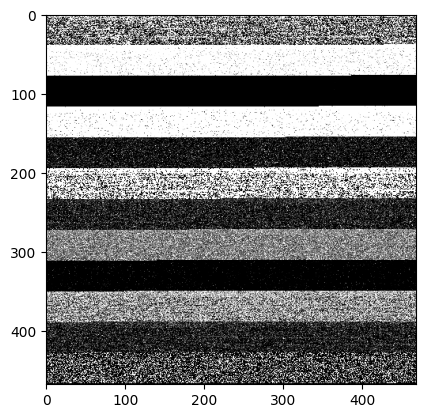

In [14]:
plt.imshow(X_tensor[0].permute(1, 2, 0))

In [15]:
##from torchvision import models
##models.vit_h_14(weights=models.ViT_H_14_Weights.IMAGENET1K_SWAG_E2E_V1)

#timm.create_model('eva02_large_patch14_448.mim_m38m_ft_in22k_in1k', pretrained=True)

In [16]:
%%time
from sklearn.model_selection import KFold

torch.cuda.empty_cache()

def get_model():
		#model = timm.create_model('eva02_large_patch14_448.mim_m38m_ft_in22k_in1k', pretrained=True)
		#model = models.resnet152(pretrained=True)
		model = models.regnet_y_400mf(pretrained=True)
		
		num_ftrs = model.fc.in_features
		model.fc = nn.Linear(num_ftrs, y_tensor.shape[1])
		
		#num_ftrs = model.head.in_features
		#model.head = nn.Linear(num_ftrs, len(genes))

		#num_ftrs = model.classifier[6].in_features
		#model.classifier[6] = nn.Linear(num_ftrs, len(genes))

		#num_ftrs = model.head.in_features
		#model.head = nn.Linear(num_ftrs, len(genes))

		return model.cuda()

CPU times: user 20 µs, sys: 0 ns, total: 20 µs
Wall time: 24.1 µs


In [17]:

kf = KFold(n_splits=5, shuffle=True, random_state=6174)
for fold, (train_index, val_index) in enumerate(kf.split(X_tensor)):
		print(f'Fold {fold+1}')

		# Split data into training and validation sets
		X_train_tensor, y_train_tensor = X_tensor[train_index], y_tensor[train_index]
		X_val_tensor, y_val_tensor = X_tensor[val_index], y_tensor[val_index]
		
		# Move data to GPU
		X_train_tensor, y_train_tensor = X_train_tensor.cuda(), y_train_tensor.cuda()
		X_val_tensor, y_val_tensor = X_val_tensor.cuda(), y_val_tensor.cuda()

		# DataLoader setup
		train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
		val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
		train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
		val_loader = DataLoader(val_dataset, batch_size=16)

		# Model, loss, optimizer setup
		model = get_model()
		criterion = nn.MSELoss()
		optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
		scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

		# Training loop for each fold
		best_val_loss = float('inf')
		early_stopping_patience = 10
		early_stopping_counter = 0
		gradient_clip_value = 1
		
		for epoch in range(num_epochs):
				model.train()
				for inputs, targets in train_loader:
						optimizer.zero_grad()
						outputs = model(torchvision.transforms.Resize(448)(inputs))
						#outputs = model(inputs)
						loss = criterion(outputs, targets)
						loss.backward()
						torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip_value)  # Gradient clipping
						optimizer.step()

				# Validation loop
				model.eval()
				valid_loss_squared_sum = 0  # For MRRMSE

				with torch.no_grad():
						for inputs, targets in val_loader:
								outputs = model(torchvision.transforms.Resize(448)(inputs))
								loss = criterion(outputs, targets)
								valid_loss_squared_sum += loss.item() * inputs.size(0)  # Sum of squared errors
						valid_mrrmse = np.sqrt(valid_loss_squared_sum / len(val_loader.dataset))
						print(f'Epoch {epoch}, MRRMSE: {valid_mrrmse}')

						# Update the learning rate scheduler based on validation loss
						scheduler.step(valid_mrrmse)

						if valid_mrrmse < best_val_loss:
								best_val_loss = valid_mrrmse
								early_stopping_counter = 0
								torch.save(model.state_dict(), f'best_model_fold_{fold+1}.pth')  # Save best model checkpoint
						else:
								early_stopping_counter += 1
								if early_stopping_counter >= early_stopping_patience:
										print("Early stopping triggered")
										print()
										break
		print()

Fold 1


Downloading: "https://download.pytorch.org/models/regnet_y_400mf-c65dace8.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_400mf-c65dace8.pth


  0%|          | 0.00/16.8M [00:00<?, ?B/s]

Epoch 0, MRRMSE: 23.068864067245745
Epoch 1, MRRMSE: 23.149074646268026
Epoch 2, MRRMSE: 20.846646483832608
Epoch 3, MRRMSE: 20.20923452066321
Epoch 4, MRRMSE: 22.573837846376026
Epoch 5, MRRMSE: 21.01260624606285
Epoch 6, MRRMSE: 20.50230963815246
Epoch 7, MRRMSE: 20.522643979244595
Epoch 8, MRRMSE: 18.458173529633974
Epoch 9, MRRMSE: 20.927175684118534
Epoch 10, MRRMSE: 21.166766705903527
Epoch 11, MRRMSE: 21.86544079905351
Epoch 12, MRRMSE: 18.409779994798885
Epoch 13, MRRMSE: 18.55311745595569
Epoch 14, MRRMSE: 19.211300709265164
Epoch 15, MRRMSE: 17.637265623378077
Epoch 16, MRRMSE: 18.088070163134702
Epoch 17, MRRMSE: 21.347124057516528
Epoch 18, MRRMSE: 19.113318337532966
Epoch 19, MRRMSE: 20.121767870894722
Epoch 20, MRRMSE: 20.539545615129242
Epoch 21, MRRMSE: 19.22278061459281
Epoch 00022: reducing learning rate of group 0 to 1.0000e-04.
Epoch 22, MRRMSE: 18.640496449721127
Epoch 23, MRRMSE: 17.413946473168334
Epoch 24, MRRMSE: 17.516530238996484
Epoch 25, MRRMSE: 17.42937298

In [18]:
from sklearn.metrics import mean_squared_error

def predict(model, X_data, y_svd=None, is_image_format=False):
    """
    Preprocess the features if needed, predict using the trained model, and inverse transform the predictions.
    """
    if not is_image_format:
        #X_scaled = X_scaler.transform(X_data)
        X_img = convert_to_image_format(X_data.values)
        X_tensor = torch.tensor(X_img, dtype=torch.float32).permute(0, 3, 1, 2).cuda()
    else:
        X_tensor = X_data

    model.eval()
    with torch.no_grad():
        test_outputs = model(torchvision.transforms.Resize(448)(X_tensor))
        
    test_predictions = test_outputs.cpu().numpy()
    if y_svd is not None:
        test_predictions = y_svd.inverse_transform(test_predictions)
    
    return test_predictions

ensemble_cv_predictions = []

# Load models and collect their predictions for the validation and test set
for fold in range(1, 6):
    # Load the pre-trained model
    model = get_model()
    checkpoint_path = f'best_model_fold_{fold}.pth'
    model.load_state_dict(torch.load(checkpoint_path))
    model = model.cuda()
    
    # Make predictions on the validation set
    # X_val_tensor is already in image format, no need for scaling
    val_predictions = predict(model, X_val, y_svd=y_svd)
    ensemble_cv_predictions.append(val_predictions)
    
  
# Calculate the average prediction across all folds
ensemble_cv_predictions = np.mean(ensemble_cv_predictions, axis=0)

# We can also calculate the ensemble CV score if 'y_val_tensor' holds the true validation labels
ensemble_mrrmse = np.sqrt(mean_squared_error(y_val, ensemble_cv_predictions))
print(f'Ensemble CV MRRMSE: {ensemble_mrrmse}')

Ensemble CV MRRMSE: 1.608369109190658


In [21]:
# Train again by using all data

# Convert scaled data to image format
X_img = convert_to_image_format(X.values)

y_svd = TruncatedSVD(n_components=n_components, random_state=6174)
y_truncated = y_svd.fit_transform(y.values)

# Convert to tensors
X_tensor = torch.tensor(X_img, dtype=torch.float32).permute(0, 3, 1, 2)
y_tensor = torch.tensor(y_truncated, dtype=torch.float32)

# KFold setup
num_epochs = 50  # Define the number of epochs

kf = KFold(n_splits=5, shuffle=True, random_state=6174)
for fold, (train_index, val_index) in enumerate(kf.split(X_tensor)):
		print(f'Fold {fold+1}')

		# Split data into training and validation sets
		X_train_tensor, y_train_tensor = X_tensor[train_index], y_tensor[train_index]
		X_val_tensor, y_val_tensor = X_tensor[val_index], y_tensor[val_index]

		# Move data to GPU
		X_train_tensor, y_train_tensor = X_train_tensor.cuda(), y_train_tensor.cuda()
		X_val_tensor, y_val_tensor = X_val_tensor.cuda(), y_val_tensor.cuda()

		# DataLoader setup
		train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
		val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
		train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
		val_loader = DataLoader(val_dataset, batch_size=16)

		# Model, loss, optimizer setup
		model = get_model()
		criterion = nn.MSELoss()
		optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
		scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

		# Training loop for each fold
		best_val_loss = float('inf')
		early_stopping_patience = 10
		early_stopping_counter = 0
		gradient_clip_value = 1

		for epoch in range(num_epochs):
				model.train()
				for inputs, targets in train_loader:
						optimizer.zero_grad()
						outputs = model(torchvision.transforms.Resize(448)(inputs))
						loss = criterion(outputs, targets)
						loss.backward()
						torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip_value)  # Gradient clipping
						optimizer.step()

				# Validation loop
				model.eval()
				valid_loss_squared_sum = 0  # For MRRMSE

				with torch.no_grad():
						for inputs, targets in val_loader:
								outputs = model(torchvision.transforms.Resize(448)(inputs))
								loss = criterion(outputs, targets)
								valid_loss_squared_sum += loss.item() * inputs.size(0)  # Sum of squared errors
						valid_mrrmse = np.sqrt(valid_loss_squared_sum / len(val_loader.dataset))
						print(f'Epoch {epoch}, MRRMSE: {valid_mrrmse}')

						# Update the learning rate scheduler based on validation loss
						scheduler.step(valid_mrrmse)

						if valid_mrrmse < best_val_loss:
								best_val_loss = valid_mrrmse
								early_stopping_counter = 0
								torch.save(model.state_dict(), f'best_model_fold_{fold+1}.pth')  # Save best model checkpoint
						else:
								early_stopping_counter += 1
								if early_stopping_counter >= early_stopping_patience:
										print("Early stopping triggered")
										print()
										break
		print()


ensemble_sub_predictions = []
for fold in range(1, 6):
		# Load the pre-trained model
		model = get_model()
		checkpoint_path = f'best_model_fold_{fold}.pth'
		model.load_state_dict(torch.load(checkpoint_path))
		model = model.cuda()
		
		# Make predictions on the test set
		# X_sub_tensor is already in image format, no need for scaling
		sub_predictions = predict(model, X_sub, y_svd=y_svd)
		ensemble_sub_predictions.append(sub_predictions)
	
# Calculate the average prediction across all folds
ensemble_sub_predictions = np.mean(ensemble_sub_predictions, axis=0)

# Save the predictions to a CSV file
id_map.loc[:, genes] = ensemble_sub_predictions
id_map = id_map.loc[:, ["id"] + genes.to_list()]
id_map.to_csv('submission.csv', index=False)
id_map

Fold 1
Epoch 0, MRRMSE: 26.140359624642812
Epoch 1, MRRMSE: 24.47807067075153
Epoch 2, MRRMSE: 23.705437468383458
Epoch 3, MRRMSE: 24.17540604805239
Epoch 4, MRRMSE: 22.773693797017536
Epoch 5, MRRMSE: 21.766485233914057
Epoch 6, MRRMSE: 22.82243213986496
Epoch 7, MRRMSE: 23.417217675395793
Epoch 8, MRRMSE: 23.242677231893833
Epoch 9, MRRMSE: 24.489228582927524
Epoch 10, MRRMSE: 27.733950547107014
Epoch 11, MRRMSE: 22.4022289801986
Epoch 00012: reducing learning rate of group 0 to 1.0000e-04.
Epoch 12, MRRMSE: 21.204235124703374
Epoch 13, MRRMSE: 21.682795019175717
Epoch 14, MRRMSE: 21.287893996004875
Epoch 15, MRRMSE: 21.146333087755615
Epoch 16, MRRMSE: 21.722695532161527
Epoch 17, MRRMSE: 21.3500948648845
Epoch 18, MRRMSE: 21.260771962640693
Epoch 19, MRRMSE: 21.300751067233495
Epoch 20, MRRMSE: 21.798977184393948
Epoch 21, MRRMSE: 21.491561511703484
Epoch 00022: reducing learning rate of group 0 to 1.0000e-05.
Epoch 22, MRRMSE: 21.35495722420602
Epoch 23, MRRMSE: 21.11967954372298


,id,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,0,0.152418,0.093741,0.088151,0.168987,0.274904,0.254671,-0.028168,0.139792,-0.072698,...,-0.014883,-0.002101,-0.016230,0.045520,0.152165,0.184724,0.160251,0.114171,-0.116645,-0.055893
1,1,0.057017,0.038327,0.053163,0.096580,0.099818,0.044371,-0.059455,0.064578,-0.096523,...,-0.041662,-0.040838,-0.073881,-0.018331,0.067952,0.103024,0.110843,0.078723,-0.037354,-0.068597
2,2,0.148235,0.095996,0.102972,0.186627,0.263712,0.235830,-0.029126,0.137206,-0.070909,...,-0.021417,0.000795,-0.011661,0.044464,0.141722,0.188345,0.161967,0.116340,-0.111649,-0.051638
3,3,0.021901,0.016009,0.031333,0.066442,0.035934,-0.036701,-0.072339,0.039942,-0.111646,...,-0.050879,-0.064542,-0.104031,-0.046411,0.037909,0.072788,0.099027,0.072605,-0.024657,-0.079504
4,4,0.058637,0.040568,0.052830,0.099786,0.103898,0.049554,-0.056239,0.069279,-0.094073,...,-0.038703,-0.041254,-0.069103,-0.015871,0.067881,0.106200,0.111524,0.080922,-0.043906,-0.067551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,250,-0.007118,-0.002175,0.011291,0.039431,-0.014901,-0.118257,-0.089444,0.019930,-0.143333,...,-0.064293,-0.096445,-0.146857,-0.075707,0.016612,0.050506,0.097044,0.076174,-0.010612,-0.100860
251,251,0.075113,0.055008,0.046460,0.091757,0.132397,0.102979,-0.054166,0.086293,-0.074877,...,-0.030349,-0.045444,-0.055245,-0.014382,0.074064,0.116479,0.118231,0.092099,-0.064388,-0.058697
252,252,-0.000731,0.004371,0.018277,0.043126,-0.007980,-0.095227,-0.088744,0.024944,-0.129578,...,-0.064844,-0.086627,-0.132784,-0.071651,0.018561,0.055591,0.097459,0.077254,-0.009866,-0.091854
253,253,0.198194,0.140053,-0.162567,-0.068166,0.365513,0.570337,0.001947,0.275763,0.038536,...,0.077866,-0.035958,-0.008415,0.076393,0.218969,0.213939,0.175194,0.181491,-0.452042,-0.073147


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


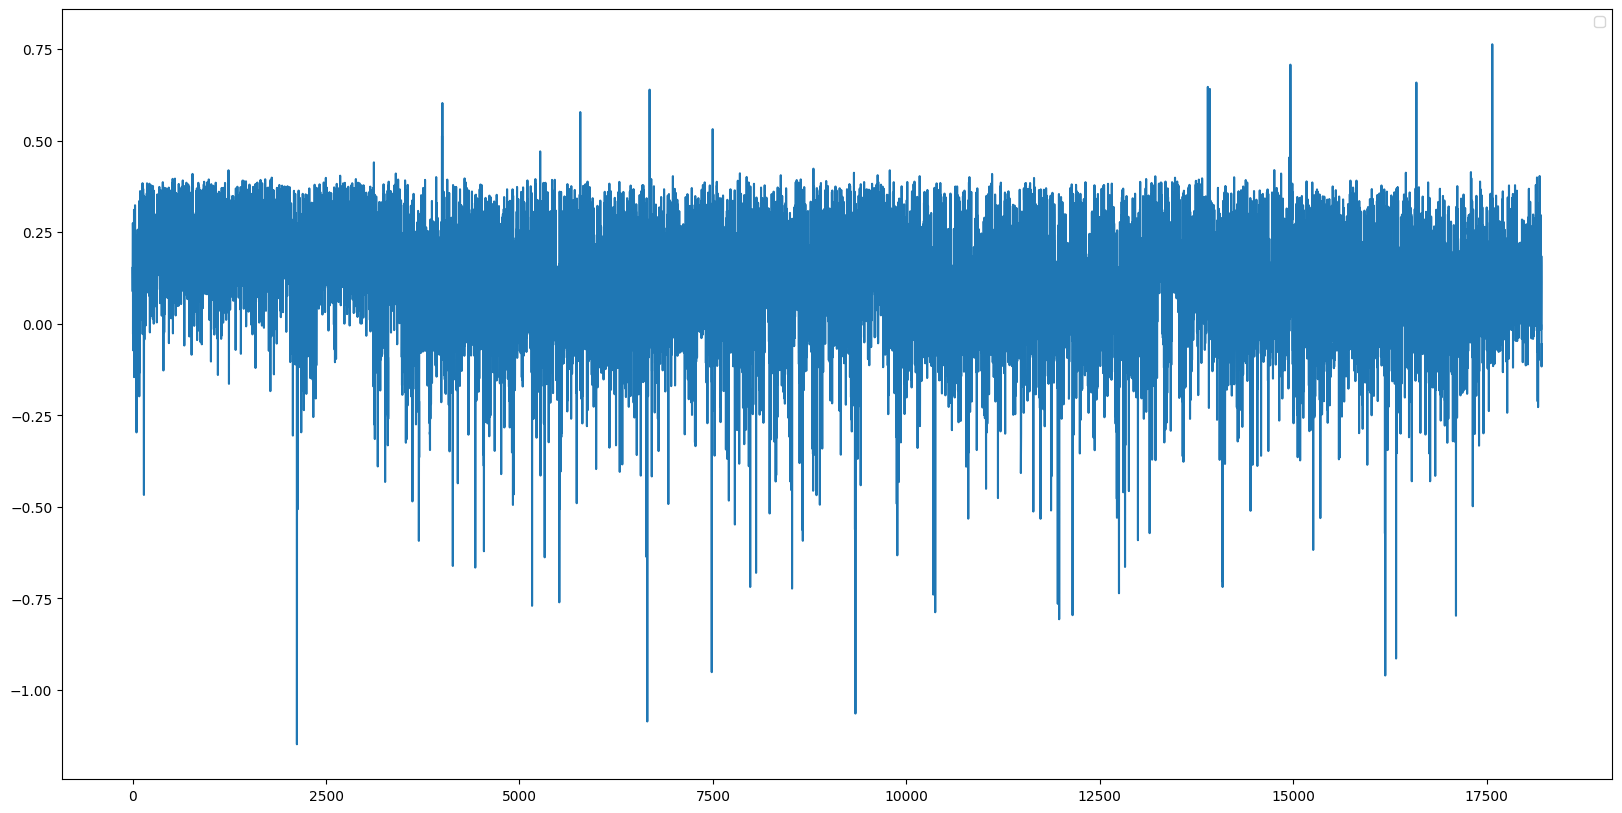

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.plot(id_map[genes].values[0])
plt.legend()
plt.show()

In [ ]:
X_tensor.shape

- sub_0: m-nb002 v25, Ridge, CV: 1.11, LB: 0.611
- sub_1: m-nb006 v5, py-boost GradientBoosting, CV: 0.977, LB: 0.591
- sub_2: m-nb014 v12, LinearSVM with flat genes, CV: 1.848, LB: 0.768
- sub_3: m-nb015 v4, regnet_y_32gf, CV: 1.691, LB: 0.630
- sub_4: s-nb001 v4, LinearRegression, CV: 1.135, LB: 0.627

In [18]:

#sub_0 = id_map.copy()
#sub_1 = pd.read_csv('/kaggle/input/opscp-subs/OPSCP-m-nb006 - Version 5.csv')
#sub_2 = pd.read_csv('/kaggle/input/opscp-subs/opscp-m-nb014 - Version 12.csv')
#sub_3 = pd.read_csv('/kaggle/input/opscp-subs/opscp-m-nb015 - Version 4.csv')
#sub_4 = pd.read_csv('/kaggle/input/opscp-subs/opscp-s-nb001 - Version 4.csv')


#diff_1_0 = sub_1[genes].values - sub_0[genes].values
#diff_2_0 = sub_2[genes].values - sub_0[genes].values
#diff_3_0 = sub_3[genes].values - sub_0[genes].values
#diff_4_0 = sub_4[genes].values - sub_0[genes].values


#plt.figure(figsize=(20, 10))
#plt.plot(diff_1_0[0], label='diff_1_0', alpha=0.5)
#plt.plot(diff_2_0[0], label='diff_2_0', alpha=0.5)
#plt.plot(diff_3_0[0], label='diff_3_0', alpha=0.5)
#plt.plot(diff_4_0[0], label='diff_4_0', alpha=0.5)
#plt.legend()
#plt.show()


In [ ]:
## Ensemble
#id_map = pd.read_csv(f'{folder_path}/id_map.csv')
#id_map.loc[:, genes] = (
#    0.25 * sub_0[genes].values +
#    0.3 * sub_1[genes].values +
#    0.1 * sub_2[genes].values +
#    0.2 * sub_3[genes].values +
#    0.15 * sub_4[genes].values
#)
#id_map = id_map.loc[:, ["id"] + genes.to_list()]
#id_map.to_csv('submission.csv', index=False)

#pd.read_csv('submission.csv')

## Plot it
#plt.figure(figsize=(20, 10))
#plt.plot(id_map[genes].values[0], label='ensemble', alpha=0.5)
#plt.plot(sub_0[genes].values[0], label='sub_0', alpha=0.2)
#plt.plot(sub_1[genes].values[0], label='sub_1', alpha=0.2)
#plt.plot(sub_2[genes].values[0], label='sub_2', alpha=0.2)
#plt.plot(sub_3[genes].values[0], label='sub_3', alpha=0.2)
#plt.plot(sub_4[genes].values[0], label='sub_4', alpha=0.2)
#plt.legend()
#plt.show()

